# Cluster Users based on Topics

*This notebook loads computed topic models from documents and clusters users based on the topics.*

In [24]:
import json
import pandas as pd
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns

session_file = '../data/lss-17k.json'
topic_file = '../data/lda_doc_topic219.csv'
topic_info_file = '../data/topic-info.csv'
output_file = '../data/lss-17k-user-clusters.json'

###  Load sessions

In [61]:
def load(filename):
    'A text file with each line as a JSON text.'
    with open(filename) as file:
        sessions = [parse_lss(line) for line in file]
    return pd.DataFrame([s for s in sessions if s])

def parse_lss(text):
    'Return the list of actions from the given JSON text.'
    obj = json.loads(text)
    if 'actionsQueue' in obj and obj['actionsQueue']:
        action = [a[6:] for a in obj['actionsQueue']] #  [6:] to exclude the prefix 'Action'
        return { 'id': obj['PFX'], 'action': action, 'userId': obj['userId'] }

In [62]:
sessions = load(session_file)
sessions.head()

,action,id,userId
0,"[SearchOffice, DisplayOneOffice, SearchUsr, Se...",:M6KR03#GP1LS1CETBTJB3N#T91:,Jann
1,"[SearchUsr, SearchUsr, SearchUsr, SearchOffice...",:WSKY82GLQI4U1CETBTJB3N#T91:,Kangaroo
2,"[SearchUsr, DisplayOneUser]",:YSLC#ZQBZ53U1M$2IA00K4$T91:,Korath the Pursuer
3,[CreateUser],:91$0PGDUU67W1UJ1DKHC4M#T91:,Frog-Man
4,"[SearchUsr, SearchUsr, SearchUsr, SearchUsr, S...",:0RASINSR3BS70U148HB10G7U91:,Dragon Lord


### Load computed topics

In [4]:
topics = pd.read_csv(topic_file)
topics.head()

,LDA6Topic4,LDA9Topic2,LDA11Topic4,LDA11Topic10,LDA12Topic1,LDA12Topic2,LDA12Topic6,LDA12Topic11,LDA13Topic11,LDA14Topic10,LDA17Topic7,LDA17Topic12,LDA19Topic15
0,0.198113,0.284404,0.729730,0.009009,0.008929,0.008929,0.008929,0.008929,0.008850,0.008772,0.008547,0.008547,0.008403
1,0.539474,0.265823,0.012346,0.012346,0.012195,0.012195,0.012195,0.012195,0.132530,0.011905,0.011494,0.011494,0.011236
2,0.038462,0.724138,0.354839,0.032258,0.031250,0.031250,0.031250,0.031250,0.030303,0.323529,0.027027,0.027027,0.025641
3,0.062500,0.052632,0.047619,0.523810,0.045455,0.045455,0.045455,0.045455,0.043478,0.041667,0.037037,0.037037,0.034483
4,0.017857,0.016949,0.016393,0.016393,0.016129,0.016129,0.016129,0.016129,0.015873,0.015625,0.014925,0.014925,0.739130


There are no IDs associated with sessions here but the order matches with our `data`.

In [5]:
topics.index == sessions.index

array([ True,  True,  True, ...,  True,  True,  True])

### Cluster users
Each user is a vector of tasks 
 - $s = (p_1, p_2, ..., p_{k})$ with $p_i$ is the probability of task $i$
 - $u=\frac{1}{m}\sum_i^{m}{s_i}$ with $s_i$ is the vector representation of tasks for session $i$

In [6]:
users = sessions.groupby('userId').apply(lambda x: topics.iloc[x.index].mean())
user_matrix = users.values
users.head()

,LDA6Topic4,LDA9Topic2,LDA11Topic4,LDA11Topic10,LDA12Topic1,LDA12Topic2,LDA12Topic6,LDA12Topic11,LDA13Topic11,LDA14Topic10,LDA17Topic7,LDA17Topic12,LDA19Topic15
userId,,,,,,,,,,,,,
A'lars,0.025956,0.280197,0.022546,0.022546,0.021976,0.021976,0.130672,0.021976,0.021437,0.233692,0.019538,0.019538,0.221424
Aardwolf,0.420947,0.102735,0.125914,0.119538,0.011959,0.021218,0.128234,0.025644,0.019082,0.037008,0.036270,0.049436,0.027411
"Abdol, Ahmet",0.025190,0.049614,0.076396,0.327260,0.011459,0.011459,0.011459,0.060964,0.011313,0.011170,0.187639,0.010763,0.235124
Abner Little,0.028915,0.012263,0.071530,0.598413,0.011752,0.011752,0.168409,0.011752,0.011592,0.074971,0.036900,0.019493,0.010724
Abominable Snowman,0.014475,0.126842,0.155753,0.013460,0.013274,0.634804,0.013274,0.013274,0.013093,0.149136,0.012419,0.012419,0.012108


Have a look at the users with dimensionality reduction.

In [7]:
mds_coords = MDS(random_state=0).fit_transform(user_matrix)

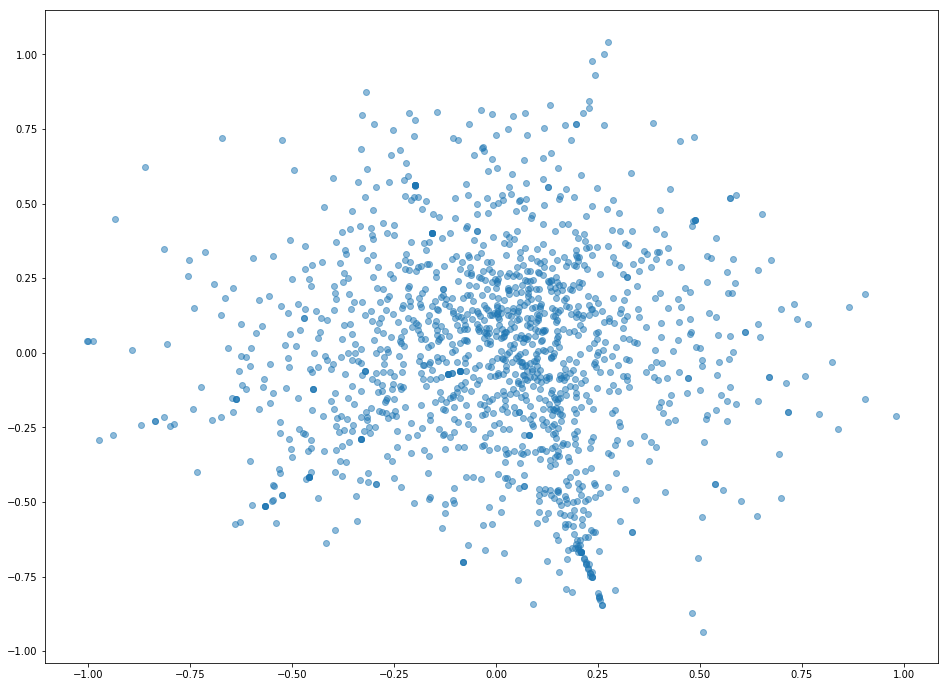

In [8]:
plt.figure(figsize=(16, 12))
plt.scatter(mds_coords[:,0], mds_coords[:,1], alpha=0.5)

In [9]:
tsne_coords = TSNE(perplexity=100, random_state=0).fit_transform(user_matrix)

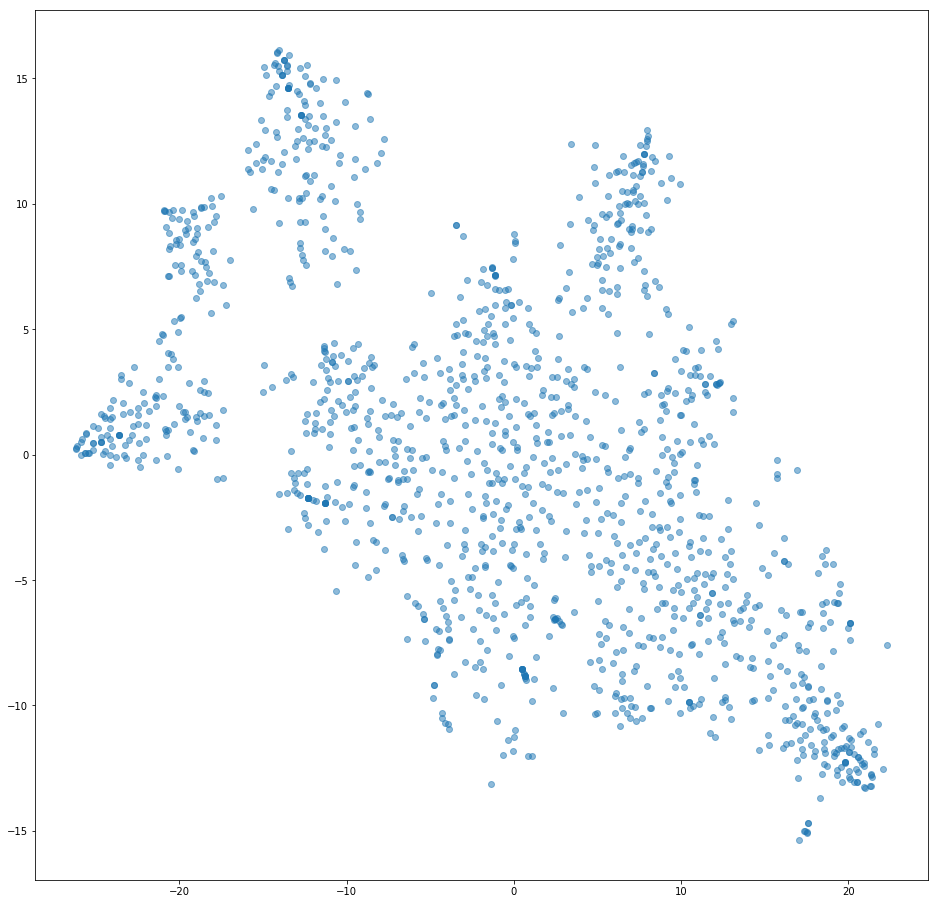

In [10]:
plt.figure(figsize=(16, 16))
plt.scatter(tsne_coords[:,0], tsne_coords[:,1], alpha=0.5)

Neither MDS nor t-nse shows visible clusters.

### Find optimal number of clusters
First, use elbow method.

In [11]:
ss = []
sa = []
num_clusters = range(2, 50)
for k in num_clusters:
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(user_matrix)
    ss.append(km.inertia_)
    sa.append(silhouette_score(user_matrix, labels))

Text(0,0.5,'Sum of squared distances')

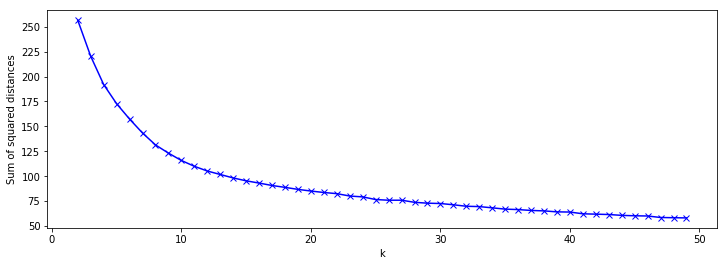

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(num_clusters, ss, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')

**Is it between 6 and 12?**

Second, use average silhouette score.

Text(0,0.5,'silhouette average')

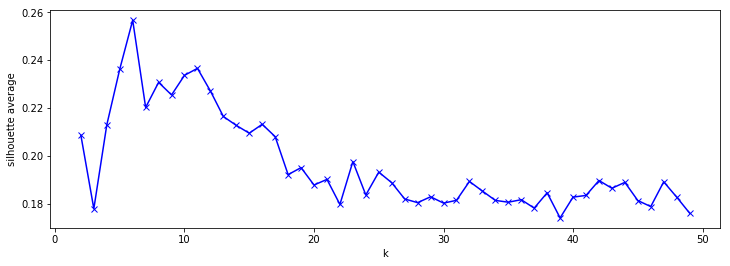

In [23]:
plt.figure(figsize=(12, 4))
plt.plot(num_clusters, sa, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette average')

The maximum one is 6, the second highest one is 11. Both are in the range 6 - 12 in the elbow method. Let's color code the clusters using t-sne.

In [51]:
def plot_user_clusters(n, ax):
    km = KMeans(n_clusters=n, random_state=0)
    labels = km.fit_predict(user_matrix)
    ax.scatter(tsne_coords[:,0], tsne_coords[:,1], alpha=0.5, c=labels, cmap=plt.cm.get_cmap('Set3'))    
    ax.set_title(str(n) + ' clusters')

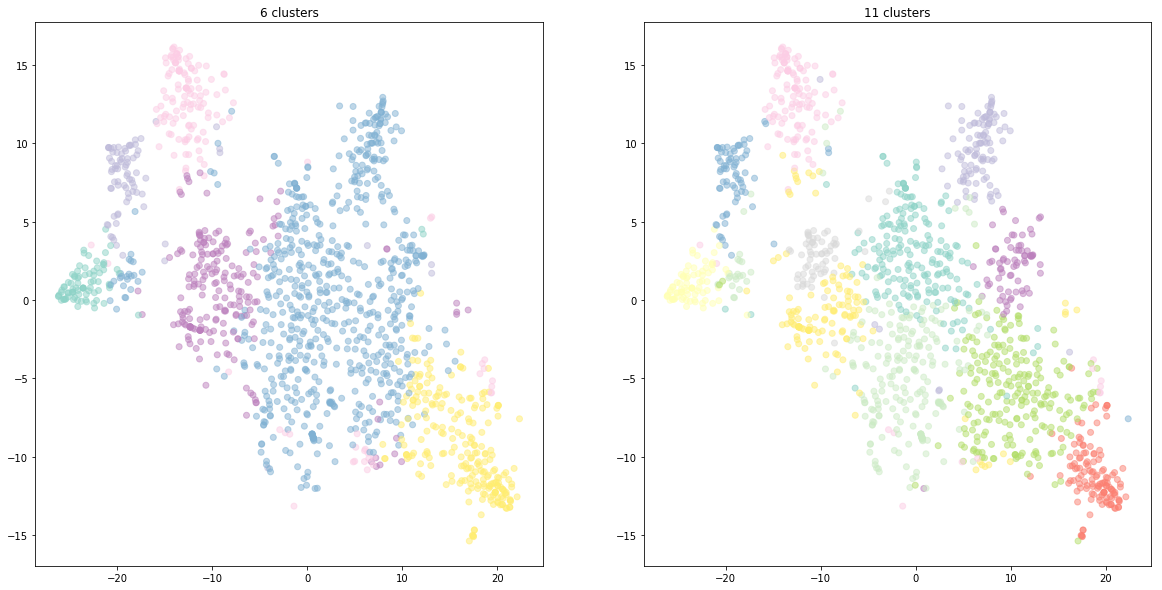

In [52]:
f, (p1, p2) = plt.subplots(1, 2)
f.set_size_inches(20, 10)
plot_user_clusters(6, p1)
plot_user_clusters(11, p2)

Also, look at how tasks are distributed in each clustering.

In [16]:
def heatmap_cluster(n, ax):
    km = KMeans(n_clusters=n, random_state=0)
    users['cluster'] = km.fit_predict(user_matrix)
    cluster_matrix = users.groupby('cluster').mean().values
    sns.heatmap(cluster_matrix, cmap='Reds', ax=ax)
    ax.set_title(str(n) + ' clusters')

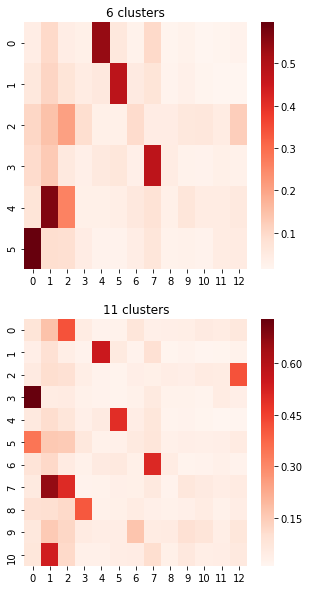

In [17]:
f, (p1, p2) = plt.subplots(2, 1)
f.set_size_inches(5, 10)
heatmap_cluster(6, p1)
heatmap_cluster(11, p2)

Hmm, many topics do not appear in the user clusters. Let's see what are the 13 topics about.

In [18]:
topic_info = pd.read_csv(topic_info_file, index_col=0)
topic_info.head()

,ActionDuplicateRoleUnitary,ActionLaunRemDelegACL,ActionFilterGlobalRoles,ActionRemoveOgu,ActionUpdateOGUConfirmation,ActionRemoveACL,ActionShowMatchingOffices,ActionUnlockOfficePop,ActionUpdateOGUStep2,ActionRemoveAttribute,...,ActionFilterHistory,ActionUpDataConfirm,ActionSearchParentRole,ActionCreateOrgaUnit,ActionDuplicateRole,ActionCreateACLConfirmation3,ActionCreateCompositeRole,ActionSearchCrossApp,ActionLoadSignsTemplate,ActionUpdateSAPCmd
Topics,,,,,,,,,,,,,,,,,,,,,
LDA6Topic4,2.750000e-07,2.750000e-07,2.750000e-07,4.130780e-04,5.506790e-04,2.750000e-07,2.750000e-07,2.754770e-04,7.158000e-04,2.750000e-07,...,2.750000e-07,2.750000e-07,2.780000e-05,8.448973e-03,2.750000e-07,2.750000e-07,2.750000e-07,1.651487e-03,5.530000e-05,2.750000e-07
LDA9Topic2,3.340000e-07,3.340000e-07,3.340000e-07,3.340000e-07,3.340000e-07,3.340000e-07,3.340000e-07,3.340000e-07,3.340000e-07,3.340000e-07,...,1.636615e-03,3.340000e-07,3.340000e-07,3.340000e-07,3.340000e-07,3.340000e-07,3.340000e-07,3.340000e-07,3.340000e-07,3.340000e-07
LDA11Topic4,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07,...,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07,2.350000e-07
LDA11Topic10,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07,...,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07,3.970000e-07
LDA12Topic1,2.187344e-03,3.499225e-03,4.286354e-03,8.750000e-07,8.750000e-07,2.624637e-03,8.750000e-07,8.750000e-07,8.750000e-07,8.750000e-07,...,8.750000e-07,5.256270e-04,8.750000e-07,8.750000e-07,3.061931e-03,1.487674e-03,1.225297e-03,2.362261e-03,8.750000e-07,8.750000e-07


In [19]:
def print_topic(t):
    print(t.nlargest(5))
    print()
    
topic_info.apply(print_topic, axis=1)

ActionSearchOffice        0.384155
ActionDisplayOneOffice    0.297246
ActionTpfRefreshTable     0.052179
ActionAdminOguStep1       0.049399
ActionRefreshReports      0.036850
Name: LDA6Topic4, dtype: float64

ActionSearchUsr             0.561178
ActionDisplayOneUser        0.373874
ActionRemoveOneUserRole     0.024678
ActionChooseOrganization    0.012690
ActionOneUserRoleDetails    0.011321
Name: LDA9Topic2, dtype: float64

ActionSearchUsr              0.418310
ActionDisplayOneUser         0.352076
ActionUpdateUserDetails      0.140261
ActionNotifyDisplayedUser    0.048622
ActionResetPwdDisplayed      0.019049
Name: LDA11Topic4, dtype: float64

ActionCreateUser                    0.350700
ActionAssignRole1                   0.202193
ActionAssignRole2                   0.192861
ActionAssignRoleAclConfirmation1    0.181425
ActionSearchUsr                     0.022872
Name: LDA11Topic10, dtype: float64

ActionDisplayOneAppli      0.122268
ActionManageAppRole        0.069793
ActionAddDataT

Topics
LDA6Topic4      None
LDA9Topic2      None
LDA11Topic4     None
LDA11Topic10    None
LDA12Topic1     None
LDA12Topic2     None
LDA12Topic6     None
LDA12Topic11    None
LDA13Topic11    None
LDA14Topic10    None
LDA17Topic7     None
LDA17Topic12    None
LDA19Topic15    None
dtype: object

#### Export data

In [20]:
with open(output_file, 'w') as f:
    json.dump({ 'topics': all_topics, 'sessions': output_data }, f)

NameError: name 'all_topics' is not defined